[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MIT-Emerging-Talent/ET6-CDSP-group-04-repo/blob/main/2_data_preparation/data_cleaning_us_it_programs.ipynb)


# 🧼 Milestone 2: Data Cleaning Notebook
## Project: Career Pathways into IT for Displaced Youth (U.S., 2025)
**Group:** 4  
**Author:** Yuri Spizhovyi  
**Source:** [Milestone 2 – Data Preparation](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-04-repo/tree/main/2_data_preparation)  
**Repo:** [My Repo](https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-04-repo)

---

This notebook prepares our combined dataset of IT training pathways as of 2025 for analysis. We focus on accessibility, cost, completion rates, and format.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
# Clone once per session
#!git clone https://github.com/MIT-Emerging-Talent/ET6-CDSP-group-04-repo.git

# Move into the correct folder
%cd ET6-CDSP-group-04-repo
#%cd /content/

/content


## 1. Load Raw Data

In [76]:
df = pd.read_csv('1_datasets/raw_data/raw_us_it_programs.csv')
df.head()

,Provider,Program,Focus Area,Format,Length,Cost (USD),Credential Type,Completion Rate (if known),Entry-Level Friendly,Accessible (Online/Free),Source Link,SourceType
0,MIT,BS in Computer Science,Software Engineering,In-person,4 years,53000/year,Bachelor's Degree,80%,No,No,https://www.mit.edu,University
1,Stanford University,MS in Data Science,Data Science,In-person,2 years,55000/year,Master's Degree,85%,No,No,https://www.stanford.edu,University
2,UC Berkeley,BS in Electrical Engineering & Computer Sciences,Computer Science,In-person,4 years,43000/year,Bachelor's Degree,78%,No,No,https://www.berkeley.edu,University
3,Harvard Extension School,Professional Certificate in Web Dev,Web Development,Hybrid,1 year,11700,Certificate,75%,Yes,Partial,https://extension.harvard.edu,University
4,Carnegie Mellon,MS in AI & Innovation,Artificial Intelligence,In-person,2 years,56000/year,Master's Degree,87%,No,No,https://www.cmu.edu,University


### 📝 Observations & Next Steps

From the initial inspection, we observed:

- All columns are present, but several have missing values:
  - `Credential Type` is missing in 11 rows
  - `Completion Rate (if known)` is missing in 46 rows
- Columns like `Length` and `Cost (USD)` are stored as strings with inconsistent formatting (e.g., "4 years", "$39/month+")
- Some categorical columns (e.g., `Format`, `Entry-Level Friendly`) have varied text formats that need standardization

🛠️ **Based on these findings, we decided to:**
- Create new numerical columns for **program length** (`Length_Years`) and **total cost** (`Cost_Total_USD`)
- Standardize categorical columns like `Format`, `Accessible`, and `Entry-Level Friendly` for easier analysis
- Handle missing values carefully during cleaning and note them in analysis

This prepares the dataset for reliable analysis and visualization in Milestone 3.


In [77]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Provider                    150 non-null    object
 1   Program                     150 non-null    object
 2   Focus Area                  150 non-null    object
 3   Format                      150 non-null    object
 4   Length                      150 non-null    object
 5   Cost (USD)                  150 non-null    object
 6   Credential Type             139 non-null    object
 7   Completion Rate (if known)  104 non-null    object
 8   Entry-Level Friendly        150 non-null    object
 9   Accessible (Online/Free)    150 non-null    object
 10  Source Link                 150 non-null    object
 11  SourceType                  150 non-null    object
dtypes: object(12)
memory usage: 14.2+ KB


,Provider,Program,Focus Area,Format,Length,Cost (USD),Credential Type,Completion Rate (if known),Entry-Level Friendly,Accessible (Online/Free),Source Link,SourceType
count,150,150,150,150,150,150,139,104,150,150,150,150
unique,60,58,36,7,25,36,15,14,2,3,60,3
top,MIT,BS in Computer Science,Computer Science,Online,4 years,Free,Certificate,75%,Yes,Yes,https://www.mit.edu,University
freq,3,5,16,77,20,58,69,20,126,90,3,50


## 3. Normalize Program Duration (`Length`)
- We convert all durations to fractional years for comparison.
- Ranges are averaged, flexible entries are marked `NaN`.

In [78]:
def convert_length_to_years(length):
    if pd.isnull(length):
        return np.nan
    length = length.lower().strip()

    if "flexible" in length or "variable" in length:
        return np.nan

    # Handle ranges like '10–16 weeks' or '2–3 years'
    match = re.findall(r"(\d+)[^\d]+(\d+)", length)
    if match:
        low, high = map(int, match[0])
        avg = (low + high) / 2
        if "week" in length:
            return avg / 52
        elif "month" in length:
            return avg / 12
        elif "year" in length:
            return avg
    else:
        # Handle single values
        nums = re.findall(r"\d+(?:\.\d+)?", length)
        if nums:
            val = float(nums[0])
            if "week" in length:
                return val / 52
            elif "month" in length:
                return val / 12
            elif "year" in length:
                return val
    return np.nan

df["Length_Years"] = df["Length"].apply(convert_length_to_years).round(2)
df[["Length", "Length_Years"]].sample(10)


,Length,Length_Years
136,Ongoing,NaN
131,1 year,1.00
84,6 months,0.50
57,6–12 months,0.75
74,3 months,0.25
105,Variable,NaN
110,Varies,NaN
24,2 years,2.00
0,4 years,4.00
147,3–6 months,0.38


## 4. Estimate Total Program Cost (`Cost (USD)`)
- Free programs → `0`
- Monthly/yearly fees multiplied by program duration
- Flat fees retained as-is

In [79]:
def estimate_total_cost(cost_str, length_years):
    if pd.isnull(cost_str):
        return np.nan

    cost_str = cost_str.lower().strip()
    if "free" in cost_str:
        return 0

    nums = re.findall(r"\d+(?:,\d+)?", cost_str.replace(',', ''))
    if not nums:
        return np.nan

    amount = float(nums[0])

    if "/year" in cost_str and length_years:
        return amount * length_years
    elif "/month" in cost_str and length_years:
        return amount * (length_years * 12)
    else:
        return amount  # flat fee or total

df["Cost_Total_USD"] = df.apply(lambda row: estimate_total_cost(row["Cost (USD)"], row["Length_Years"]), axis=1)
df[["Cost (USD)", "Length_Years", "Cost_Total_USD"]].sample(10)


,Cost (USD),Length_Years,Cost_Total_USD
65,Free,NaN,0.00
14,52000,3.50,52000.00
62,Free,0.08,0.00
91,Free (paid cert optional),0.23,0.00
125,Free/Low-cost,NaN,0.00
47,40000/year,4.00,160000.00
141,Free,0.24,0.00
112,Free,0.23,0.00
95,$39/month+,0.33,154.44
7,40000/year,4.00,160000.00


## 5. Standardize Categorical Columns

In this step, we clean and convert text-based categorical data into a consistent and numeric format to make it easier to analyze.

### 🧩 Format: `Format_Cat`
The original `Format` column includes inconsistent labels like `"Online"`, `"online/in-person"`, or `"Online + Mentorship"`.  
We standardized these into three clean categories:
- **Online**
- **In-person**
- **Hybrid**
- And any unknown values are labeled as **Other**

This allows us to group or visualize programs by format consistently.

### 🔢 Accessibility Score: `Accessible_Binary`
We converted the `Accessible (Online/Free)` column into numerical values:
- `"Yes"` → `1` (fully accessible)
- `"Partial"` → `0.5` (somewhat accessible)
- `"No"` → `0` (not accessible)

This makes it possible to calculate averages or create visual comparisons of accessibility.

### 🔢 Entry-Level Score: `EntryLevel_Binary`
We applied the same logic to the `Entry-Level Friendly` column:
- `"Yes"` → `1` (designed for beginners)
- `"Partial"` → `0.5`
- `"No"` → `0` (not beginner friendly)

These numeric columns are useful for exploring relationships between entry-level friendliness and factors like cost, program length, or completion rate.



In [80]:
df['Format_Cat'] = df['Format'].str.lower().map({
    'online': 'Online', 'in-person': 'In-person', 'hybrid': 'Hybrid',
    'online/in-person': 'Hybrid', 'online + mentorship': 'Hybrid'
}).fillna('Other')

df['Accessible_Binary'] = df['Accessible (Online/Free)'].map({'Yes': 1, 'Partial': 0.5, 'No': 0})
df['EntryLevel_Binary'] = df['Entry-Level Friendly'].map({'Yes': 1, 'Partial': 0.5, 'No': 0})
df[['Format', 'Format_Cat', 'Accessible_Binary', 'EntryLevel_Binary']].head()

,Format,Format_Cat,Accessible_Binary,EntryLevel_Binary
0,In-person,In-person,0.0,0.0
1,In-person,In-person,0.0,0.0
2,In-person,In-person,0.0,0.0
3,Hybrid,Hybrid,0.5,1.0
4,In-person,In-person,0.0,0.0


## 6. Visualize Program Cost Distribution

To understand how program costs are distributed across all IT training pathways, we created a histogram of the `Cost_Total_USD` column.

This visualization shows:
- Most programs are low-cost or free
- A small number of programs (typically university degrees) have much higher total costs

The distribution is heavily skewed, highlighting the contrast between accessible and traditional educational pathways.

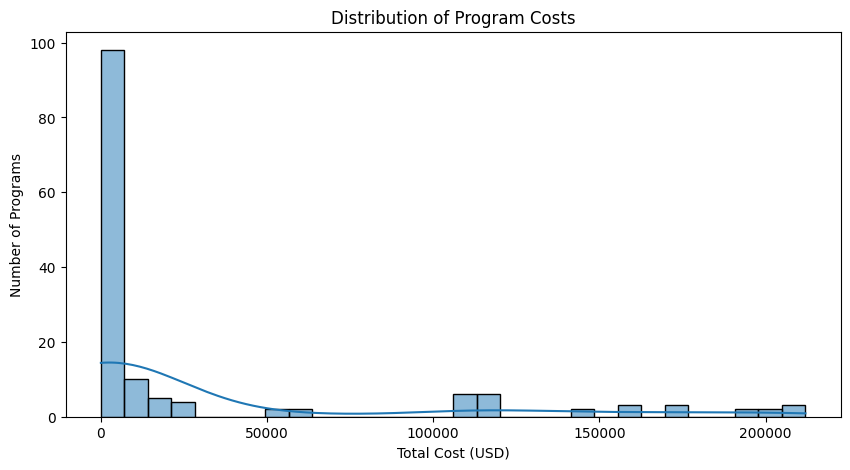

In [81]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Cost_Total_USD"], bins=30, kde=True)
plt.title("Distribution of Program Costs")
plt.xlabel("Total Cost (USD)")
plt.ylabel("Number of Programs")
plt.show()

## 7. Export Cleaned Dataset

In [82]:
df.to_csv('cleaned_us_it_programs.csv', index=False)

## ✅ Summary
- Cleaned and normalized key columns: `Cost`, `Length`, `Format`, and binary flags.
- Exported to `/cleaned_data/cleaned_us_it_programs.csv`
- Ready for Milestone 3: Analysis